In [1]:
import sys
sys.path.append("../")
import numpy as np
import matplotlib.pyplot as plt
import scripts.theodolite_utils as theodo_u
import scripts.theodolite_plot_function as theodo_p
import scripts.groundtruth_utils as theodo_g
from scipy.spatial.transform import Rotation as R
from numpy import linalg
import importlib
theodo_u = importlib.reload(theodo_u)
theodo_p = importlib.reload(theodo_p)

In [2]:
theodo_u = importlib.reload(theodo_u)

# Data we want to use
path = [
    "../data/20220224/",
    # "../data/20220307/",
    # "../data/20220312/",
    # "../data/20220314/",
    # "../data/20220316/",
    # "../data/20220331-1/",
    # "../data/20220331-2/",
    # "../data/20220427-1/",
    # "../data/20220427-2/",
    # "../data/20220513-1/",
    # "../data/20220513-2/",
    # "../data/20220513-3/",
    # "../data/20220513-4/",
    # "../data/20220513-5/",
    # "../data/20220513-6/",
    # "../data/20220525-1/",
    # "../data/20220525-2/",
    # "../data/20220622-1/",
    # "../data/20220622-2/",
    # "../data/20220630-1/",
    # "../data/20220630-2/",
    # "../data/20220711-1/",
    # "../data/20220711-2/",
    # "../data/20220715-1/",
    # "../data/20220715-2/",
    # "../data/20220715-3/",
    # "../data/20220715-4/",
    # "../data/20221103-1/",
    # "../data/20221103-2/",
    # "../data/20221103-3/",
    # "../data/20221109-1/",
    # "../data/20221109-2/",
    # "../data/20221109-3/",
    # "../data/20221110/",
    # "../data/20221116-1/",
    # "../data/20221123/",
    # "../data/20221124/",
    # "../data/20221129-1/",
    # "../data/20221129-2/",
    # "../data/20221129-3/",
    # "../data/20221129-4/",
    # "../data/20221129-5/",
    # "../data/20221205-1/",
    # "../data/20221205-2/",
    # "../data/20221205-3/"
]

# Sub path to the file of raw_data in each repository
sub_path = "uncertainty/interpolation/MC_Fake_"
model_chosen_list = [
    "0_0_0_0_0_5",
    "0_0_0_1_0_5",
]

Sensor = "GNSS"
path_sensor_file = "gps_data/"+"gps1.txt"
path_sensor_file_synch_time = "gps_data/delay_synchronization_GNSS_1.txt"  # If applied to GNSS
Gps_reference_chosen = 1    # 1: front, 2: back, 3: middle   # Only for GNSS

# Limit acceptable for ground truth error
limit_taken_into_accout = False
limit_dist = 100  # Need to check the impact
limit_uncertainty = 100 # Limit of eigenvalues taken into account

num_samples_MC_sensor = 100   ## Number sample for uncertainty propagation to the sensor
want_sensor_pose = True      ## Compute sensor uncertainty
save_MC_sensor = True        ## Save sensor pose with uncertainty

In [4]:
theodo_g = importlib.reload(theodo_g)
theodo_u = importlib.reload(theodo_u)

# Compute covariance of all measurements for the dataset selected and model chosen
Data_uncertainty_total = []
for model_chosen in model_chosen_list:
    print("Model chosen: ", model_chosen)
    for file_path in path:
        print(file_path)

        # Reading sensor extrinsic calibration
        file_sensors = theodo_u.if_file_exist(file_path + "sensors_extrinsic_calibration/calibration_results.csv",'')
        extrinsic_calibration_results = theodo_u.read_extrinsic_calibration_results_file(file_sensors)

        ## Read sensor data which we want a ground truth
        sensor_data = []
        if Sensor == "GNSS":
            GNSS_raw_data = theodo_u.read_prediction_data_Linear_csv_file(file_path+path_sensor_file)
            time_delay = float(theodo_u.read_time_delay(file_path+path_sensor_file_synch_time))

            for i in GNSS_raw_data:
                raw_data = np.array([i[0] + time_delay, i[1], i[2], i[3], 0, 0, 0, 1])
                sensor_data.append(raw_data)
            sensor_data = np.array(sensor_data)

        if Sensor == "Robosense_32":
            sensor_data = theodo_u.read_icp_odom_file(file_path+path_sensor_file)
            sensor_data = np.array(sensor_data)

        P1 = theodo_u.read_point_uncertainty_csv_file(file_path+sub_path+model_chosen+"_1.csv")
        P2 = theodo_u.read_point_uncertainty_csv_file(file_path+sub_path+model_chosen+"_2.csv")
        P3 = theodo_u.read_point_uncertainty_csv_file(file_path+sub_path+model_chosen+"_3.csv")

        MC_1_sorted = []
        MC_2_sorted = []
        MC_3_sorted = []
        if limit_taken_into_accout:
            for i1,j1,k1 in zip(P1,P2,P3):
                d1 = abs(np.linalg.norm(i1[1]-j1[1])-extrinsic_calibration_results[0])
                d2 = abs(np.linalg.norm(i1[1]-k1[1])-extrinsic_calibration_results[1])
                d3 = abs(np.linalg.norm(k1[1]-j1[1])-extrinsic_calibration_results[2])
                if d1<limit_dist and d2<limit_dist and d3<limit_dist:
                    MC_1_sorted.append(i1)
                    MC_2_sorted.append(j1)
                    MC_3_sorted.append(k1)
        else:
            MC_1_sorted = P1
            MC_2_sorted = P2
            MC_3_sorted = P3

        if want_sensor_pose==True:
            P_sensor = theodo_g.chose_sensor_before_ptp(file_path, Sensor, Gps_reference_chosen)
            Pose_sensor_MC = []
            for i_mc,j_mc,k_mc in zip(MC_1_sorted,MC_2_sorted,MC_3_sorted):
                Pose_sensor = []
                p1_corrected = theodo_g.return_point_from_covariance(i_mc[2],i_mc[1], num_samples_MC_sensor)
                p2_corrected = theodo_g.return_point_from_covariance(j_mc[2],j_mc[1], num_samples_MC_sensor)
                p3_corrected = theodo_g.return_point_from_covariance(k_mc[2],k_mc[1], num_samples_MC_sensor)
                for i,j,k in zip(p1_corrected,p2_corrected,p3_corrected):
                    Q = np.array([i, j, k]).T
                    Q =np.concatenate((Q, np.array([[1,1,1]])), axis=0)
                    T = theodo_u.point_to_point_minimization(P_sensor, Q)
                    Pose_sensor.append(T)
                mu_T, cov_matrix_T, mu_A, cov_matrix_A = theodo_g.find_noise_list_tf(Pose_sensor)
                Pose_sensor_MC.append([i[0], mu_T, cov_matrix_T, mu_A, cov_matrix_A])

            if save_MC_sensor:
                if Sensor=="GNSS":
                    theodo_u.save_MC_pose_sorted(Pose_sensor_MC, file_path + "uncertainty/sensor/"+Sensor+"_"+str(Gps_reference_chosen)+"_"
                                                         +str(model_chosen[0])+"_"+str(model_chosen[2])+"_"+str(model_chosen[4])
                                                     +"_"+str(model_chosen[6])+"_"+str(model_chosen[8])+".csv")
                else:
                    theodo_u.save_MC_pose_sorted(Pose_sensor_MC, file_path + "uncertainty/sensor/"+Sensor+"_"
                                                         +str(model_chosen[0])+"_"+str(model_chosen[2])+"_"+str(model_chosen[4])
                                                     +"_"+str(model_chosen[6])+"_"+str(model_chosen[8])+".csv")

        print("Interpolation finished !")


Model chosen:  0_0_0_0_0_5
../data/20220224/
Conversion done !
Interpolation finished !
Model chosen:  0_0_0_1_0_5
../data/20220224/
Conversion done !
Interpolation finished !


In [6]:
theodo_u = importlib.reload(theodo_u)

Pose_0 = theodo_u.read_pose_uncertainty_sorted("../data/20220224/uncertainty/sensor/GNSS_1_0_0_0_0_0.csv")
Pose_1 = theodo_u.read_pose_uncertainty_sorted("../data/20220224/uncertainty/sensor/GNSS_1_0_0_0_1_0.csv")

In [9]:
theodo_g = importlib.reload(theodo_g)

Data_total = [Pose_0,Pose_1]
## Frobenius norm for all data according to the model chosen and the range linked
Parameter_RTS_total = []    # Here the parameters linked to the metric (range for instance)
Distance_F_total_t = []
Distance_F_total_a = []
Number_model = 1
for model in Data_total[1:]:
    print(Number_model)
    Number_model=Number_model+1
    Distance_F_t = []
    Distance_F_a = []
    Parameter_RTS = []
    for value_model, value_0 in zip(model, Data_total[0]):
        Distance_F_t.append(np.sqrt(theodo_u.Frobenius_norm(value_model[2], value_0[2])))
        Distance_F_a.append(np.sqrt(theodo_u.Frobenius_norm(value_model[4], value_0[4])))
        Parameter_RTS.append(value_0[3][0])
    Distance_F_total_t.append(Distance_F_t)
    Distance_F_total_a.append(Distance_F_a)
    Parameter_RTS_total.append(Parameter_RTS)

1


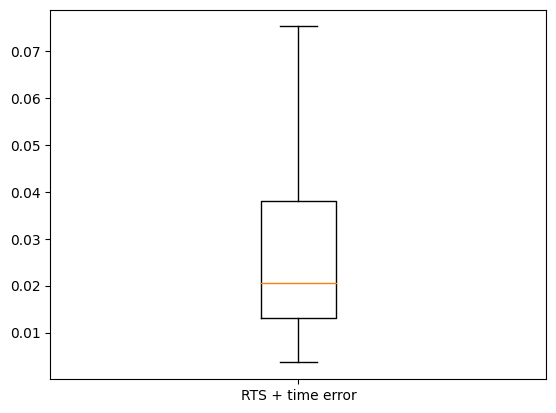

In [11]:
data = Distance_F_total_t
fig, ax = plt.subplots()
ax.boxplot(data, showfliers=False, notch=False)
ax.set_xticklabels(['RTS + time error'])
#ax.set_xticklabels(['RTS + Tilt', 'RTS + \nAtmospheric', 'RTS + \nExtrinsic calib', 'RTS + time error', 'RTS + All'])
#ax.set_xticklabels(['RTS + \nExtrinsic calib', 'RTS + All'])
plt.show()

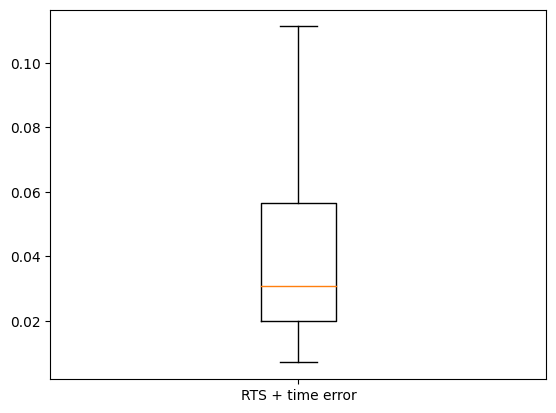

In [12]:
data = Distance_F_total_a
fig, ax = plt.subplots()
ax.boxplot(data, showfliers=False, notch=False)
ax.set_xticklabels(['RTS + time error'])
#ax.set_xticklabels(['RTS + Tilt', 'RTS + \nAtmospheric', 'RTS + \nExtrinsic calib', 'RTS + time error', 'RTS + All'])
#ax.set_xticklabels(['RTS + \nExtrinsic calib', 'RTS + All'])
plt.show()